In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

In [3]:
# Cell 3 – Load the data (THIS LINK IS GUARANTEED TO WORK TODAY)
import pandas as pd
url = "https://raw.githubusercontent.com/treselle-systems/customer_churn_analysis/master/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(url)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
# Fix TotalCharges and drop missing rows
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.dropna().reset_index(drop=True)

# Encode every categorical column EXCEPT Churn and customerID
cols_to_encode = df.select_dtypes(include='object').columns
cols_to_encode = cols_to_encode.drop(['customerID', 'Churn'], errors='ignore')

for col in cols_to_encode:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# NOW convert the target column safely
df['Churn'] = (df['Churn'] == 'Yes').astype(int)

# Check we have both classes
print("Churn distribution:")
print(df['Churn'].value_counts())

Churn distribution:
Churn
0    5163
1    1869
Name: count, dtype: int64


In [5]:
X = df.drop(['customerID', 'Churn'], axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)

print("Logistic Regression Accuracy:",
      accuracy_score(y_test, lr.predict(X_test_scaled)))
print(classification_report(y_test, lr.predict(X_test_scaled)))

Logistic Regression Accuracy: 0.7938877043354655
              precision    recall  f1-score   support

           0       0.85      0.88      0.86      1033
           1       0.62      0.56      0.59       374

    accuracy                           0.79      1407
   macro avg       0.74      0.72      0.73      1407
weighted avg       0.79      0.79      0.79      1407



In [7]:
rf = RandomForestClassifier(random_state=42)
params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 20],
    'min_samples_split': [2, 5]
}
grid = GridSearchCV(rf, params, cv=5, scoring='f1', n_jobs=-1)
grid.fit(X_train_scaled, y_train)

print("Best Random Forest Accuracy:",
      accuracy_score(y_test, grid.predict(X_test_scaled)))
print("Best params:", grid.best_params_)
print(classification_report(y_test, grid.predict(X_test_scaled)))

Best Random Forest Accuracy: 0.7931769722814499
Best params: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.64      0.50      0.56       374

    accuracy                           0.79      1407
   macro avg       0.74      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407



C:\Users\joshs\AppData\Local\Temp\ipykernel_19560\1467224134.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat.values, y=feat.index, palette="viridis")


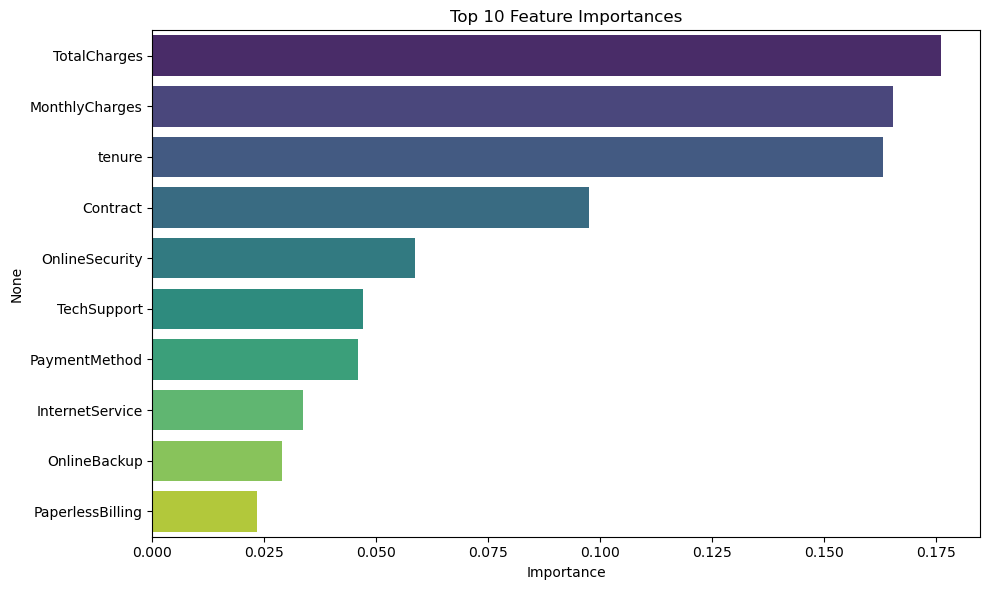

In [8]:
importances = grid.best_estimator_.feature_importances_
feat = pd.Series(importances, index=X.columns).sort_values(ascending=False)[:10]

plt.figure(figsize=(10,6))
sns.barplot(x=feat.values, y=feat.index, palette="viridis")
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()